In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
from plots import *

%matplotlib inline

%reload_ext autoreload
%autoreload 2

c:\Users\Bruker\anaconda3\envs\4D_CT\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
rotation_rate = 21 # degrees per second. For Industrial
avg_frames = 12 # Number of frames to average over
frames_per_sec = 5 # 1/seconds # Correct? For Micro. Choose, or do both



In [4]:
def V3_revolution(nproj, rr, avgf, fps, add_on=5 ):
    """
    Calculates scan time of one revolution with GoldenRatioV3
    nproj: number of projections
    rr: rotation rate in degrees per second
    avgf: number of frames to average over
    fps: frames per second
    add_on: number of seconds to add on to the scan time
    """

    exposure = nproj * avgf/fps
    rot = 360/rr
    scan_time = exposure + rot + add_on

    exposure_ratio = exposure/scan_time
    return scan_time, exposure_ratio

def V3_angles(nproj, nrevs, starting=0):
    angles = np.zeros((nrevs, nproj))

    golden_angle_sampling = lambda n, inc: np.mod((n * 1/((np.sqrt(5) - 1) / 2) * inc), inc)

    startings = golden_angle_sampling(np.arange(starting,nrevs), 360/nproj)

    linear_sampling = lambda s: np.linspace(s, s + 360, nproj, endpoint=False)

    return linear_sampling(startings).T

def V3_total_time( rr, avgf, fps, add_on=5,nproj=None, nrevs=None,total = None):

    if total is None:
        total = nproj * nrevs
    elif nproj is None:
        nproj = total//nrevs
    elif nrevs is None:
        nrevs = total//nproj       
    else:
        raise ValueError
    
    scan_time_rev, exposure_ratio = V3_revolution(nproj, rr, avgf, fps, add_on)

    return scan_time_rev * nrevs, exposure_ratio

def standard_CT_time_exposure(nproj, rr, avgf, fps, add_on=0):
    return V3_revolution(nproj, rr, avgf, fps, add_on)

def theoretical_golden_angle(nproj, rr, avgf, fps, add_on=0 ):

    rotation = 137.5/rr
    exposure = avgf/fps
    scan_time = (rotation + exposure + add_on)*nproj
    exposure_ratio = nproj*exposure/scan_time
    return scan_time, exposure_ratio

def experimental_golden_angle(nproj, rr, avgf, fps, add_on=5):
    metallic_means = lambda n: (180* (n + np.sqrt(n**2 +4)))%360
    golden= metallic_means(1)
    golden = np.min([golden, np.abs(360-golden)])
    angles = np.arange(0, nproj* golden, golden)%360
    rotations = np.array([np.abs(angles[i] - angles[i-1]) for i in range(1, len(angles))])

    rotation = np.sum(rotations/rr)
    exposure = nproj*avgf/fps
    scan_time = rotation + exposure + add_on*nproj
    exposure_ratio = exposure/scan_time
    return scan_time, exposure_ratio
    

    


In [5]:
nrevs = np.arange(1, 51)
nproj = 25

V3_tots, V3_exps = V3_total_time(rotation_rate, avg_frames, frames_per_sec, nproj=nproj, nrevs=nrevs)
std_tots, std_exps = standard_CT_time_exposure(nproj*nrevs, rotation_rate, avg_frames, frames_per_sec)
theo_tots, theo_exps = theoretical_golden_angle(nproj*nrevs, rotation_rate, avg_frames, frames_per_sec)
experiment_tots, experiment_exps = np.array([experimental_golden_angle(nproj*nr, rotation_rate, avg_frames, frames_per_sec) for nr in nrevs]).T

totals = 1000
nprojs = totals//nrevs #np.arange(10, 100)
print(nprojs)

V3_tots2 = np.zeros((len(nprojs), len(nrevs)))
V3_exps2 = np.zeros((len(nprojs), len(nrevs)))

for i, nproj in enumerate(nprojs):
    V3_tots2[i], V3_exps2[i] = V3_total_time(rotation_rate, avg_frames, frames_per_sec, nproj=nproj, nrevs=nrevs)

[1000  500  333  250  200  166  142  125  111  100   90   83   76   71
   66   62   58   55   52   50   47   45   43   41   40   38   37   35
   34   33   32   31   30   29   28   27   27   26   25   25   24   23
   23   22   22   21   21   20   20   20]


C:\Users\Bruker\AppData\Local\Temp\ipykernel_18740\3353678257.py:103: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(X_diag2.min(), X_diag2.max())


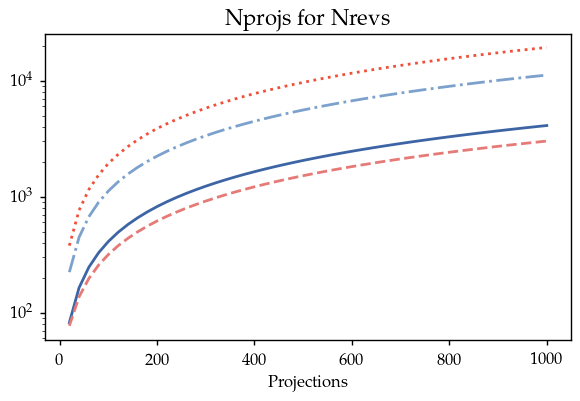

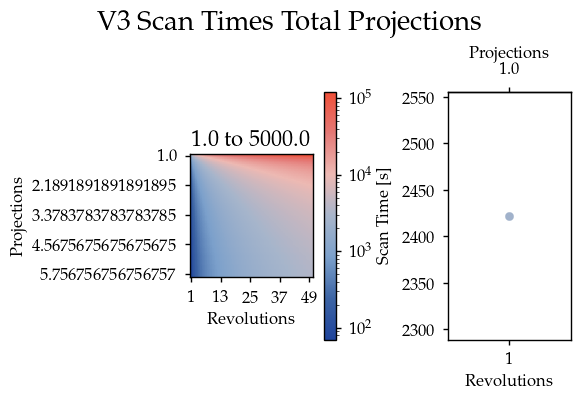

In [84]:
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
def plot_tot_time_comparison(nproj, nrevs, V3_tots, std_tots, theo_tots, experiment_tots, title="Nprojs for Nrevs", savefig=False, ax=False):
    choose_formatter(False)

    if ax is False:
        fig,ax = plt.subplots()
    else:
        ax = ax

    ax.plot(nrevs*nproj, V3_tots, label="V3")
    ax.plot(nrevs*nproj, std_tots, label="Standard")
    ax.plot(nrevs*nproj, theo_tots, label="GR Theory")
    ax.plot(nrevs*nproj, experiment_tots, label="GR Exp")

    if ax is False:
        ax.legend()
        ax.set_ylabel("Scan time [s]")


    ax.set_yscale("log")
    ax.set_title(title)
    ax.set_xlabel("Projections")


    if savefig and ax is False:
        plt.savefig(f"../Results/Golden Angle/{title}.pdf", format="pdf")

    if ax is False:
        plt.show()
    else:
        return ax

def plot_final_time_comparison(fig,axes, gs, savefig=False):
    choose_formatter(False)

    ax = axes[0]
    ax1 = axes[1]

    ax1.sharey(ax)
    ax.set_ylabel("Scan time [s]")

    # ax1.legend()
    # plt.legend( bbox_to_anchor=(0.2, -0.4),
    #       ncol=2, fancybox=True, shadow=False)
    ax_legend = fig.add_subplot(gs[2,:])
    ax_legend.axis("off")
    ax_legend.legend(*ax.get_legend_handles_labels(), loc="center", ncol=2, fancybox=True, shadow=False)

    if savefig:
        plt.savefig(f"../Results/Golden Angle/Scan_time_comparison.pdf", format="pdf")

    plt.show()

def plot_V3_grid(nproj, nrevs, V3_tots, V3_exps, title="V3 Scan Times Total Projections", ticks=12, savefig=False):

    X,Y = np.meshgrid(nrevs, nproj)
    # fig,axs = plt.subplots(2,1)
    fig = plt.figure(figsize=(5.69, 3.9))
    gs = GridSpec(4,4, figure=fig)
    ax = fig.add_subplot(gs[:,0:2])
    # ax_bar = fig.add_subplot(gs[0,2])
    # ax, ax1 = axs

    ax.imshow(V3_tots, cmap = XRDCT_palette_cmp,norm= mpl.colors.LogNorm())
    # axs[1].pcolormesh(X,Y, V3_exps, cmap=XRDCT_palette_cmp)

    ax.set_xlabel("Revolutions")
    # ax.set_xlim(X.min(), X.max())
    # ax.set_ylim(Y.min(), Y.max())
    ax.set_ylabel("Projections")
    ax.set_xticks(np.arange(0,len(nrevs), ticks))
    ax.set_yticks(np.arange(0,len(nproj), ticks))
    ax.set_yticklabels(nproj[::ticks])
    ax.set_xticklabels(nrevs[::ticks])
    # ax.set_xticklabels(nrevs)
    low = np.min(X)*np.min(Y)
    high = np.max(X)*np.max(Y)
    ax.set_title(f"{low} to {high}")

    plt.colorbar(ax.imshow(V3_tots, cmap = XRDCT_palette_cmp, norm= mpl.colors.LogNorm()), ax=ax, label="Scan Time [s]")
    plt.suptitle(title)

    diag = np.diag(V3_tots)
    X_diag = np.diag(X)
    Y_diag = np.diag(Y)


    diag = diag[np.where(X_diag*Y_diag == nproj[0]*nrevs[0])]
    X_diag2 = X_diag[np.where(X_diag*Y_diag == nproj[0]*nrevs[0])]
    Y_diag2 = Y_diag[np.where(X_diag*Y_diag == nproj[0]*nrevs[0])]

    def proj_to_rev(x):
        return x
        

    def rev_to_proj(x):
        return x

    ax1 = fig.add_subplot(gs[:,2:])
    ax1.scatter(X_diag2, diag, alpha=1, c= diag, cmap = XRDCT_palette_cmp, norm= mpl.colors.LogNorm(vmin=V3_tots.min(), vmax=V3_tots.max()), )
    ax1.plot(X_diag2, diag, ":",alpha=0.5, )
    ax1.set_xlim(X_diag2.min(), X_diag2.max())


    ax2 = ax1.secondary_xaxis('top', functions=(rev_to_proj, proj_to_rev)) #ax1.twiny()



    # ax2.plot(Y_diag2[::-1], diag, alpha=1)
    ax1.set_xlabel("Revolutions")
    ax1.set_xticks(X_diag2[::ticks//4])
    ax1.set_xticklabels(X_diag2[::ticks//4])




    ax2.set_xlabel("Projections")  
    ax2.set_xticks(X_diag2[::ticks//4])
    ax2.set_xticklabels(Y_diag2[::ticks//4])

    if savefig:
        plt.savefig(f"../Results/Golden Angle/{title}.pdf", format="pdf" )
    plt.show()



plot_tot_time_comparison(nproj, nrevs, V3_tots, std_tots, theo_tots, experiment_tots, title="Nprojs for Nrevs")

plot_V3_grid(nprojs, nrevs, V3_tots2, V3_exps2)

In [7]:
choose_formatter(incscape=False)


def plot_temp_resolution(nprojs, scan_times, exp_ratios, title= "Golden Ratio V3 Sampling", markers= [], savefig=False):
    """
    Plots the temporal resolution of the scan
    nprojs: number of projections
    scan_time: scan time in seconds
    """
    fig, ax = plt.subplots()

    ax1 = ax.twinx()
    left, = ax.plot(nprojs, scan_times, "-.", color = "#1F449C", label= "Temporal Resolution")
    right, = ax1.plot(nprojs, exp_ratios, ":", color = "#F05039", label= "Exposure Ratio")


    ax.set_xlabel('Projections per Revolution')
    # ax.set_xticks(nprojs)
    # ax.set_xticklabels([str(int(n)) for n in nprojs])
    ax.set_ylabel('Temporal Resolution (s)', color = left.get_color())
    ax1.set_ylabel('Exposure Ratio', color = right.get_color())

    ax.tick_params(axis='y', colors=left.get_color())
    ax1.tick_params(axis='y', colors=right.get_color())

    # plt.legend(handles=[left, right])

    if markers != []:
        mark_plot(markers, ax, ax1, scan_times, exp_ratios, nprojs)
        

    plt.title(title)
    if savefig:
        plt.savefig(f"../Results/Golden Angle/{title}.pdf", format="pdf") # Save figure, locate Results folder
    plt.show()

def mark_plot(markers, ax, ax1, scan_times, exp_ratios, nprojs):

    for m in markers:
            try:
                arg = np.argwhere(np.isclose(nprojs, [m], rtol=1e-2))[0][0]
                r = scan_times[arg]
                e = exp_ratios[arg]
                # ax.axvline(m, color = "black", linestyle = "--")
                ax.scatter(m, r, color = "black", marker = "o")
                ax.text(m+2, r-15, f"{m}: {int(r)}s {int(e*100)}\%", rotation=0, verticalalignment='bottom')
            except:
                print(f"Marker {m} not found in nprojs. Excluded from plot")
                pass
            finally:
                 continue
    return



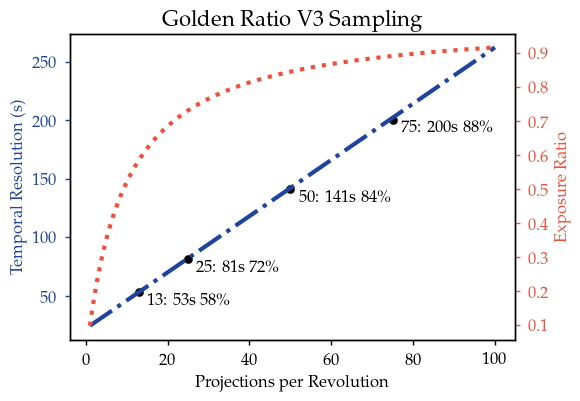

In [8]:
nprojs = np.linspace(1, 100, 1000)
times, ratios = V3_revolution(nprojs, rotation_rate, avg_frames, frames_per_sec)
markers = [13, 25, 50, 75]
plot_temp_resolution(nprojs, times, ratios, markers=markers)

In [91]:
def main():
    rotation_rates = [21,12] # degrees per second. For Industrial
    avg_frames = 12 # Number of frames to average over
    frames_per_sec = [10,5] # 1/seconds # Correct? For Micro. Choose, or do both
    titles = ["Industrial", "Micro"]

    axes = []
    fig = plt.figure(figsize=DEFAULT_FIGSIZE)
    gs = fig.add_gridspec(3, 2, hspace=0.0, wspace=0.0)

    for i in range(len(rotation_rates)):

        nrevs = np.arange(1, 51)
        nproj = 25

        V3_tots, V3_exps = V3_total_time(rotation_rates[i], avg_frames, frames_per_sec[i], nproj=nproj, nrevs=nrevs)
        std_tots, std_exps = standard_CT_time_exposure(nproj*nrevs, rotation_rates[i], avg_frames, frames_per_sec[i])
        theo_tots, theo_exps = theoretical_golden_angle(nproj*nrevs, rotation_rates[i], avg_frames, frames_per_sec[i])
        experiment_tots, experiment_exps = np.array([experimental_golden_angle(nproj*nr, rotation_rates[i], avg_frames, frames_per_sec[i]) for nr in nrevs]).T

        axes.append(plot_tot_time_comparison(nproj, nrevs, V3_tots, std_tots, theo_tots, experiment_tots, title=f"{titles[i]} V3 {nproj} Projections", savefig=True, ax=fig.add_subplot(gs[:2,i])))

        nrevs = np.arange(5, 55)
        totals = 1000
        nprojs = totals//nrevs 

        V3_tots2 = np.zeros((len(nprojs), len(nrevs)))
        V3_exps2 = np.zeros((len(nprojs), len(nrevs)))

        for j, nproj in enumerate(nprojs):
            V3_tots2[j], V3_exps2[j] = V3_total_time(rotation_rates[i], avg_frames, frames_per_sec[i], nproj=nproj, nrevs=nrevs)



        # plot_V3_grid(nprojs, nrevs, V3_tots2, V3_exps2, title= f"{titles[i]} V3 Scan Times Total Projections", savefig=True)
        
        nprojs = np.linspace(1, 100, 1000)
        times, ratios = V3_revolution(nprojs, rotation_rates[i], avg_frames, frames_per_sec[i])
        markers = [13, 25, 50, 75]


        # plot_temp_resolution(nprojs, times, ratios, markers=markers, title=f"{titles[i]} V3 Temporal Resolution", savefig=True)
    
    plot_final_time_comparison(fig, axes, gs, savefig=False)

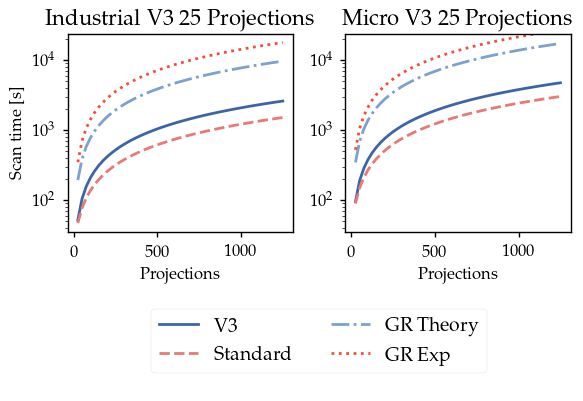

In [92]:
main()

In [168]:
%history

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
from plots import *

%matplotlib inline

%reload_ext autoreload
%autoreload 2
rotation_rate = 21 # degrees per second
avg_frames = 12 # Number of frames to average over
frames_per_sec = 5 # 1/seconds # Correct?
nrevs = np.arange(1, 50)
nproj = 50

V3_tots, V3_exps = V3_total_time(rotation_rate, avg_frames, frames_per_sec, nproj=nproj, nrevs=nrevs)
std_tots, std_exps = standard_CT_time_exposure(nproj*nrevs, rotation_rate, avg_frames, frames_per_sec)
theo_tots, theo_exps = theoretical_golden_angle(nproj*nrevs, rotation_rate, avg_frames, frames_per_sec)
experiment_tots, experiment_exps = experimental_golden_angle(nproj*nrevs, rotation_rate, avg_frames, frames_per_sec)
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
from plots import *

%matplotlib inline

%reload_e